# Finding balance between corrective and preventative maintenance using predictive maintenance

### Authors: Anant Jain, Viral Patel

# Data source

The common data elements for predictive maintenance problems can be summarized as follows:

* Machine features: The features specific to each individual machine, e.g. engine size, make, model, location, installation date.
* Telemetry data: The operating condition data collected from sensors, e.g. temperature, vibration, operating speeds, pressures.
* Maintenance history: The repair history of a machine, e.g. maintenance activities or component replacements, this can also include error code or runtime message logs.
* Failure history: The failure history of a machine or component of interest.

It is possible that failure history is contained within maintenance history, either as in the form of special error codes or order dates for spare parts. In those cases, failures can be extracted from the maintenance data. Additionally, different business domains may have a variety of other data sources that influence failure patterns which are not listed here exhaustively. These should be identified by consulting the domain experts when building predictive models.

Some examples of above data elements from use cases are:
    
**Machine conditions and usage:** Flight routes and times, sensor data collected from aircraft engines, sensor readings from ATM transactions, train events data, sensor readings from wind turbines, elevators and connected cars.
    
**Machine features:** Circuit breaker technical specifications such as voltage levels, geolocation or car features such as make, model, engine size, tire types, production facility etc.

**Failure history:** fight delay dates, aircraft component failure dates and types, ATM cash withdrawal transaction failures, train/elevator door failures, brake disk replacement order dates, wind turbine failure dates and circuit breaker command failures.

**Maintenance history:** Flight error logs, ATM transaction error logs, train maintenance records including maintenance type, short description etc. and circuit breaker maintenance records.

Given the above data sources, the two main data types we observe in predictive maintenance domain are temporal data and static data. Failure history, machine conditions, repair history, usage history are time series indicated by the timestamp of data collection. Machine and operator specific features, are more static, since they usually describe the technical specifications of machines or operator’s properties.

# Step 1:  Data Ingestion and Exploratory Analysis

## Imports

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

### Machines data set

This simulation tracks a simulated set of 1000 machines over the course of a single year (2015). 

This data set includes information about each machine: Machine ID, model type and age (years in service). 

In [2]:
machines = pd.read_csv('machines.csv', encoding='utf-8')
machines.head()

,machineID,model,age
0,1,model2,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model2,2


In [3]:
machines.describe()

,machineID,age
count,1000.000000,1000.000000
mean,500.500000,9.862000
std,288.819436,6.092789
min,1.000000,0.000000
25%,250.750000,5.000000
50%,500.500000,10.000000
75%,750.250000,15.000000
max,1000.000000,20.000000


The following figure plots a histogram of the machines age colored by the specific model.

D:\Workspace\Python\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


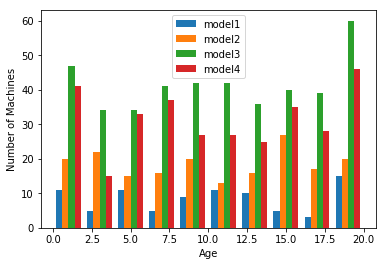

In [4]:
plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age')
plt.ylabel('Number of Machines')
plt.legend()
plt.show()

The figure shows how long the collection of machines have been in service. It indicates there are four model types, shown in different colors, and all four models have been in service over the entire 20 years of service. The machine age will be a feature in our analysis, since we expect older machines may have a different set of errors and failures then machines that have not been in service long.

### Errors  data set

The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate.

In [5]:
errors = pd.read_csv('errors.csv', encoding='utf-8')
errors.head()

,datetime,machineID,errorID
0,2015-01-06 03:00:00,1,error3
1,2015-02-03 06:00:00,1,error4
2,2015-02-21 11:00:00,1,error1
3,2015-02-21 16:00:00,1,error2
4,2015-03-20 06:00:00,1,error1


In [6]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors.count()

datetime     11967
machineID    11967
errorID      11967
dtype: int64

The following histogram details the distribution of the errors tracked in the log files. 

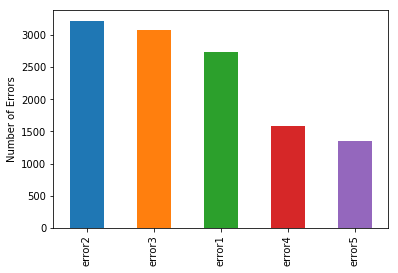

In [7]:
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Number of Errors')
plt.show()

The error data consists of a time series (datetime stamped) of error codes thrown by each machine (machineID). The figure shows how many errors occured in each of the five error classes over the entire year. We could split this figure over each individual machine, but with 1000 individuals, the figure would not be very informative.

### Maintenance data set

The maintenance log contains both scheduled and unscheduled maintenance records. Scheduled maintenance corresponds with  regular inspection of components, unscheduled maintenance may arise from mechanical failure or other performance degradations. A failure record is generated for component replacement in the case  of either maintenance events. Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).

In [8]:
maint = pd.read_csv('maint.csv', encoding='utf-8')
maint.head()

,datetime,machineID,comp
0,2014-07-01 06:00:00,1,comp4
1,2014-09-14 06:00:00,1,comp1
2,2014-09-14 06:00:00,1,comp2
3,2014-11-13 06:00:00,1,comp3
4,2015-01-05 06:00:00,1,comp1


In [9]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint.count()

datetime     32592
machineID    32592
comp         32592
dtype: int64

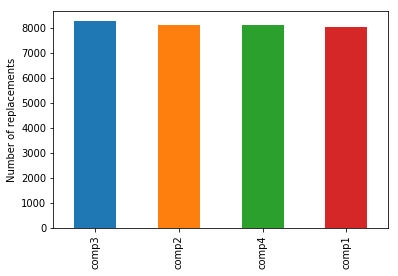

In [10]:
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Number of replacements')
plt.show()

The figure shows a histogram of component replacements divided into the four component types over the entire maintenance history. It looks like these four components are replaced at similar rates.

There are many ways we might want to look at this data including calculating how long each component type lasts, or the time history of component replacements within each machine. This will take some preprocess of the data, which we are delaying until we do the feature engineering steps.

### Telemetry data set

The telemetry time-series data consists of voltage, rotation, pressure, and vibration sensor measurements collected from each  machines in real time. The data is averaged over an hour and stored in the telemetry logs.

In [11]:
telemetry = pd.read_csv('telemetry.csv', encoding='utf-8')
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,1,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,1,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,1,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,1,180.544277,371.600611,107.553307,41.467880


In [12]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06
mean,5.005000e+02,1.707600e+02,4.466014e+02,1.008371e+02,4.034961e+01
std,2.886750e+02,1.550153e+01,5.261507e+01,1.099671e+01,5.337052e+00
min,1.000000e+00,8.778085e+01,1.021730e+02,4.862230e+01,1.435719e+01
25%,2.507500e+02,1.602964e+02,4.123434e+02,9.351999e+01,3.676380e+01
50%,5.005000e+02,1.705825e+02,4.475924e+02,1.004187e+02,4.021151e+01
75%,7.502500e+02,1.810046e+02,4.821119e+02,1.075293e+02,4.374465e+01
max,1.000000e+03,2.726818e+02,7.001998e+02,1.952711e+02,7.910749e+01


Rather than plot 8.7 million data points, this figure plots a month of measurements for a single machine. This is representative of each feature repeated for every machine over the entire year of sensor data collection.

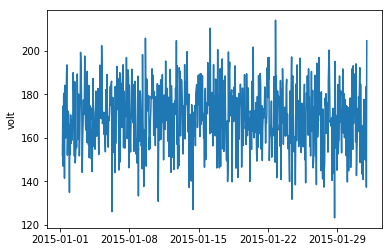

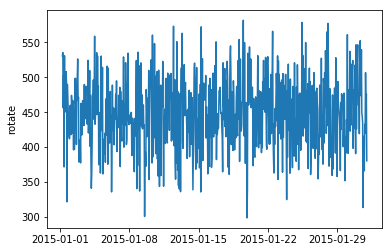

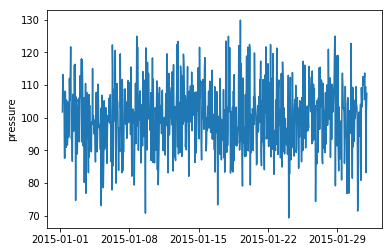

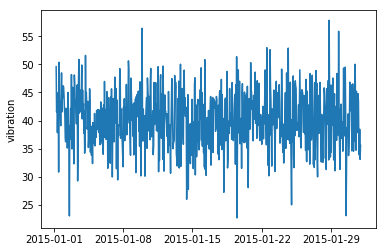

In [13]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt', 'rotate', 'pressure', 'vibration']]

plt.plot(df['datetime'], df['volt'])
plt.ylabel('volt')
plt.show()
plt.plot(df['datetime'], df['rotate'])
plt.ylabel('rotate')
plt.show()
plt.plot(df['datetime'], df['pressure'])
plt.ylabel('pressure')
plt.show()
plt.plot(df['datetime'], df['vibration'])
plt.ylabel('vibration')
plt.show()

### Failures data set

Failures correspond to component replacements within the maintenance log. Each record contains the Machine ID, component type, and replacement datetime. These records will be used to create the machine learning labels we will be trying to predict.

The figure shows one month worth of telemetry sensor data for one machine. Each sensor is shown in it's own panel.

In [14]:
failures = pd.read_csv('failures.csv', encoding='utf-8')
failures.head()

,datetime,machineID,failure
0,2015-02-04 06:00:00,1,comp3
1,2015-03-21 06:00:00,1,comp1
2,2015-04-05 06:00:00,1,comp4
3,2015-05-05 06:00:00,1,comp3
4,2015-05-20 06:00:00,1,comp2


In [15]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures.count()

datetime     6726
machineID    6726
failure      6726
dtype: int64

The following histogram details the distribution of the failure records obtained from failure log. This log was built originally from component replacements the maintenance log file. 

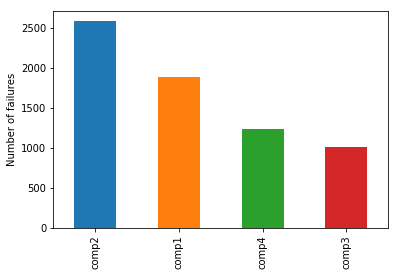

In [16]:
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Number of failures')
plt.show()

The figure shows failure related replacements occured for each of the 4 component types over the entire year.

# Step 2: Feature engineering 

Our feature engineering will combine the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The ultimate goal is to generate a single record for each time unit within each asset. The record combines features and labels to be fed into the machine learning algorithm.

Predictive maintenance take historical data, marked with a timestamp, to predict current health of a component and the probability of failure within some future window of time. These problems can be characterised as a _classification method_ involving _time series_ data. Time series, since we want to use historical observations to predict what will happen in the future. Classification, because we classify the future as having a probability of failure.

### Lag features

There are many ways of creating features from the time series data. We start by dividing the duration of data collection into time units where each record belongs to a single point in time for each asset. The measurement unit for is in fact arbitrary. Time can be in seconds, minutes, hours, days, or months, or it can be measured in cycles, miles or transactions. The measurement choice is typically specific to the use case domain.

Additionally, the time unit does not have to be the same as the frequency of data collection. For example, if temperature values were being collected every 10 seconds, picking a time unit of 10 seconds for analysis may inflate the number of examples without providing any additional information if the temperature changes slowly. A better strategy may be to average the temperature over a longer time horizon which might better capture variations that contribute to the target outcome.

Once we set the frequency of observations, we want to look for trends within measures, over time, in order to predict performance degradation, which we would like to connect to how likely a component will fail. We create features for these trends within each record using time lags over previous observations to check for these performance changes. The lag window size $W$ is a hyper parameter that we can optimize. The following figures indicate a _rolling aggregate window_ strategy for averaging a measure $t_i$ over a window $W = 3$ previous observations.

![Rolling windows](../images/rolling-aggregate-features.png)

We are note constrained to averages, we can roll aggregates over counts, average, the standard deviation, outliers based on standard deviations, CUSUM measures, minimum and maximum values for the window. 

We could also use a tumbling window approach, if we were interested in a different time window measure than the frequncy of the observations. For example, we might have obersvations evert 6 or 12 hours, but want to create features aligned on a day or week basis.  
![Tumbling windows](../images/tumbling-aggregate-features.png)

In the following sections, we will build our features using only a rolling strategy to demonstrate the process. We align our data, and then build features along those normalized observations times. We start with the telemetry data.

## Telemetry features

Because the telemetry data set is the largest time series data we have, we start feature engineering here. The telemetry data has 8761000 hourly observations for out 1000 machines. We can improve the model performance by aligning our data by aggregating average sensor measures on a tumbling 12 hour window. In this case we replace the raw data with the tumbling window data, reducing the sensor data to 731000 observations. This will directly reduce the computaton time required to do the feature engineering, labeling and modeling required for our solution.    

Once we have the reduced data, we set up our lag features by compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over time. 

The following code blocks alignes the data on 12 hour observations and calculates a rolling mean and standard deviation of the telemetry data over the last 12, 24 and 36 hour lags.

In [17]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).mean().resample('12H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_12h = pd.concat(temp, axis=1)
telemetry_mean_12h.columns = [i + 'mean_12h' for i in fields]
telemetry_mean_12h.reset_index(inplace=True)
telemetry_mean_12h = telemetry_mean_12h.loc[-telemetry_mean_12h['voltmean_12h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).std().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_sd_12h = pd.concat(temp, axis=1)
telemetry_sd_12h.columns = [i + 'sd_12h' for i in fields]
telemetry_sd_12h.reset_index(inplace=True)
telemetry_sd_12h = telemetry_sd_12h.loc[-telemetry_sd_12h['voltsd_12h'].isnull()]

In [18]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).mean().resample('12H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).std().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

In [26]:
telemetry_feat = pd.concat([telemetry_mean_12h,
                            telemetry_sd_12h.ix[:, 2:6],
                            telemetry_mean_24h.ix[:, 2:6],
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_12h,rotatemean_12h,pressuremean_12h,vibrationmean_12h,voltsd_12h,rotatesd_12h,pressuresd_12h,vibrationsd_12h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000
mean,500.500000,170.759128,446.609585,100.836497,40.349084,14.707291,49.127996,9.854067,4.915801,170.758742,446.610480,100.836500,40.349053,14.918198,49.890548,10.037140,4.997416
std,288.675188,5.712698,21.216195,5.232821,2.292131,3.193583,10.710131,2.219156,1.082040,4.699595,18.047447,4.644161,1.984154,2.260502,7.690400,1.707467,0.796001
min,1.000000,148.918494,240.555739,86.499636,33.282624,3.132666,10.366925,2.231350,1.069356,155.812721,265.786152,89.602349,35.180444,6.210934,19.468158,3.756494,1.899192
25%,250.750000,167.228630,438.433805,98.141429,39.074348,12.470419,41.643277,8.325662,4.163477,168.061923,441.580787,98.696793,39.349888,13.361240,44.612521,8.915474,4.459913
50%,500.500000,170.244885,449.054520,100.145988,40.077281,14.575053,48.683220,9.735461,4.865620,170.198761,449.203001,100.122834,40.065254,14.843160,49.561593,9.913607,4.954711
75%,750.250000,173.387910,459.156515,102.233761,41.123582,16.797384,56.090431,11.234719,5.609491,172.451111,456.385248,101.616973,40.813814,16.393824,54.780142,10.968420,5.479875
max,1000.000000,225.106859,516.419586,166.739169,63.894733,35.667974,118.183889,30.070135,13.129524,224.651654,498.664658,162.459319,62.664375,29.123530,113.941829,28.643578,12.025817


In [27]:
print(telemetry_feat.count())

machineID            729000
datetime             729000
voltmean_12h         729000
rotatemean_12h       729000
pressuremean_12h     729000
vibrationmean_12h    729000
voltsd_12h           729000
rotatesd_12h         729000
pressuresd_12h       729000
vibrationsd_12h      729000
voltmean_24h         729000
rotatemean_24h       729000
pressuremean_24h     729000
vibrationmean_24h    729000
voltsd_24h           729000
rotatesd_24h         729000
pressuresd_24h       729000
vibrationsd_24h      729000
dtype: int64


## Errors features

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type within a lag window. 

Again, we align the error counts data by tumbling over the 12 hour window using a join with telemetry data. 

In [28]:
error_ = pd.get_dummies(errors["errorID"])
error_count = pd.concat([errors["datetime"], 
                         errors["machineID"], 
                         error_], axis=1).dropna()
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()

error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06
mean,5.005000e+02,3.121790e-04,3.676521e-04,3.506449e-04,1.818286e-04,1.536354e-04
std,2.886750e+02,1.766583e-02,1.917073e-02,1.872223e-02,1.348316e-02,1.239402e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.507500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.005000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.502500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [29]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).sum().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000
mean,500.500000,0.007494,0.008826,0.008421,0.004364,0.003690
std,288.675188,0.086480,0.093721,0.091545,0.066017,0.060633
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,250.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,500.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,750.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1000.000000,2.000000,2.000000,2.000000,2.000000,1.000000


## Days since last replacement from maintenance 

A crucial data set in this example is the use of maintenance records, which contain the information regarding component replacement. Possible features from this data set can be the number of replacements of each component over time or to calculate how long it has been since a component has been replaced. Replacement time is expected to correlate better with component failures since the longer a component is used, the more degradation would be expected.

As a side note, creating lagging features from maintenance data is not straight forward. This type of ad-hoc feature engineering is very common in predictive maintenance as domain knowledge plays a crucial role in understanding the predictors of a failure problem. In the following code blocks, the days since last component replacement are calculated for each component from the maintenance data. We start by counting the component replacements for the set of machines.

In [30]:
# create a column for each error type
comp_ = pd.get_dummies(maint["comp"])
comp_rep = pd.concat([maint["machineID"], 
                         maint["datetime"], 
                         comp_ ], axis=1).dropna()

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - pd.to_datetime(comp_rep[comp])).apply(lambda x: x / pd.Timedelta(days=1))
    
comp_rep.describe()


,machineID,comp1,comp2,comp3,comp4
count,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06,8.761000e+06
mean,5.005000e+02,5.337777e+01,5.294512e+01,5.159591e+01,5.308505e+01
std,2.886750e+02,5.922694e+01,5.939801e+01,5.733418e+01,5.960321e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.507500e+02,1.308333e+01,1.295833e+01,1.266667e+01,1.295833e+01
50%,5.005000e+02,3.220833e+01,3.175000e+01,3.091667e+01,3.179167e+01
75%,7.502500e+02,6.966667e+01,6.862500e+01,6.758333e+01,6.862500e+01
max,1.000000e+03,4.389583e+02,4.339583e+02,3.989583e+02,4.529583e+02


## Machine features

The machine features capture specifics of the individuals. These can be used without further modification since it include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

We do need to create a set of dummy features, a set of boolean variables, to indicate the model of the machine.

In [31]:
mod = pd.get_dummies(machines['model'])
machines['model'] = tuple(zip(mod.model1,mod.model2,mod.model3,mod.model4))

## Merging feature data

Next, we merge the telemetry, maintenance, machine and error feature data sets into a large feature data set. Since most of the data has already been aligned on the 12 hour observation period, we can merge with a simple join strategy.

In [32]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.describe()

,machineID,voltmean_12h,rotatemean_12h,pressuremean_12h,vibrationmean_12h,voltsd_12h,rotatesd_12h,pressuresd_12h,vibrationsd_12h,voltmean_24h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,...,729000.000000,729000.000000,729000.000000,729000.000000,729000.000000,728000.000000,728000.000000,728000.000000,728000.000000,729000.000000
mean,500.500000,170.759128,446.609585,100.836497,40.349084,14.707291,49.127996,9.854067,4.915801,170.758742,...,0.007494,0.008826,0.008421,0.004364,0.003690,53.257865,52.820198,51.466714,52.957393,9.862000
std,288.675188,5.712698,21.216195,5.232821,2.292131,3.193583,10.710131,2.219156,1.082040,4.699595,...,0.086480,0.093721,0.091545,0.066017,0.060633,59.152141,59.317405,57.241221,59.517514,6.089746
min,1.000000,148.918494,240.555739,86.499636,33.282624,3.132666,10.366925,2.231350,1.069356,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000
25%,250.750000,167.228630,438.433805,98.141429,39.074348,12.470419,41.643277,8.325662,4.163477,168.061923,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.750000,12.750000,12.750000,5.000000
50%,500.500000,170.244885,449.054520,100.145988,40.077281,14.575053,48.683220,9.735461,4.865620,170.198761,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.250000,31.750000,30.750000,31.750000,10.000000
75%,750.250000,173.387910,459.156515,102.233761,41.123582,16.797384,56.090431,11.234719,5.609491,172.451111,...,0.000000,0.000000,0.000000,0.000000,0.000000,69.250000,68.250000,67.250000,68.250000,15.000000
max,1000.000000,225.106859,516.419586,166.739169,63.894733,35.667974,118.183889,30.070135,13.129524,224.651654,...,2.000000,2.000000,2.000000,2.000000,1.000000,438.750000,433.750000,398.750000,452.750000,20.000000


# Label construction

Predictive maintenance is supervised learning. To train a model to predict failures requires examples of failures, and the time series of observations leading up to those failures. Additionally, the model needs examples of periods of healthy operation in order to discern the difference between the two states. The classification between these states is typically a boolean label (healthy vs failed).

Once we have the healthy vs. failure states, the predictive maintenance approach is only useful if the method will give some advanced warning of an impending failure. To accomplish this _prior warning_ criteria, we slightly modify the label definition from a _failure event_ which occurs at a specific moment in time, to a longer window of _failure event occurs within this window_. The window length is defined by the business criteria. Is knowing a failure will occur within 12 hours, enough time to prevent the failure from happening? Is 24 hours, or 2 weeks? The ability of the model to accurately predict an impending failure is dependent sizing this window. If the failure signal is short, longer windows will not help, and can actually degrade, the potential performance.   

To acheive the redefinition of failure to _about to fail_, we over label failure events, labeling all observations within the failure warning window as failed. The prediction problem then becomes estimating the probability of failure within this window. 

![over label](../images/labelling-for-binary-classification.png)

For this example scenerio, we estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 7 days due to a component failure (component 1, 2, 3, or 4). 

Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure="comp1", and so on for components 2, 3, and 4; all records not within 7 days of a component failure have failure="none".

The first step is to alighn the failure data to the feature observation time points (every 12 hours).

In [33]:
failures['datetime'] = failures['datetime'].apply(lambda x: x.replace(hour=12))

labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features['failure'] = labeled_features['failure'].fillna('none')
labeled_features = labeled_features.fillna(0.0)
labeled_features.head()



,machineID,datetime,voltmean_12h,rotatemean_12h,pressuremean_12h,vibrationmean_12h,voltsd_12h,rotatesd_12h,pressuresd_12h,vibrationsd_12h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 12:00:00,167.377318,452.034833,99.964799,44.363301,15.565892,51.456182,7.133463,3.075716,...,0.0,0.0,0.0,110.25,110.25,50.25,185.25,"(0, 1, 0, 0)",18,none
1,1,2015-01-03 00:00:00,167.502723,439.043536,103.082577,39.768041,12.445835,26.860609,9.973548,3.290649,...,0.0,0.0,0.0,110.75,110.75,50.75,185.75,"(0, 1, 0, 0)",18,none
2,1,2015-01-03 12:00:00,162.852984,454.954241,99.840514,38.193216,12.448401,49.565265,10.624707,6.560103,...,0.0,0.0,0.0,111.25,111.25,51.25,186.25,"(0, 1, 0, 0)",18,none
3,1,2015-01-04 00:00:00,175.831151,439.725525,102.623669,40.852524,16.095546,29.331879,11.818502,6.141972,...,0.0,0.0,0.0,111.75,111.75,51.75,186.75,"(0, 1, 0, 0)",18,none
4,1,2015-01-04 12:00:00,167.286938,464.254230,96.945432,44.278333,11.453878,31.113321,10.282070,3.329338,...,0.0,0.0,0.0,112.25,112.25,52.25,187.25,"(0, 1, 0, 0)",18,none


To verify we have assigned the component failure records correctly, we count the failure classes within the feature data.

In [34]:
# To get the frequency of each component failure 
labeled_features['failure'].value_counts()

none     678103
comp2     19845
comp1     15068
comp4      8955
comp3      7389
Name: failure, dtype: int64

# Step 3: Model Building

# Prepare the Training/Testing data

A fundamental practice in machine learning is to calibrate and test your model parameters on data that has not been used to train the model. Evaluation of the model requires splitting the available data into a training portion, a calibration portion and an evaluation portion. Typically, 80% of data is used to train the model and 10% each to calibrate any parameter selection and evaluate your model.

In general random splitting can be used, but since time series data have an inherent correlation between observations. For predictive maintenance problems, a time-dependent spliting strategy is often a better approach to estimate performance. For a time-dependent split, a single point in time is chosen, the model is trained on examples up to that point in time, and validated on the examples after that point. This simulates training on current data and score data collected in the future data after the splitting point is not known. However, care must be taken on labels near the split point. In this case, feature records within 7 days of the split point can not be labeled as a failure, since that is unobserved data. 

In the following code blocks, we split the data at a single point to train and evaluate this model. 

### Editing Table
1. We do not want any null values in our table, so we check if there are any.
2. Then we plot the correlation between our external factors. Red means high correlation while blue means low correlation. We want low correlation because if we have multiple columns with high correlation, it's repetitive in the machine learning model. 

In [35]:
labeled_features.isnull().values.any() 

False

### Splitting the data

In [43]:
train_y = labeled_features.loc[labeled_features['datetime'] <= pd.to_datetime('2015-09-30 12:00:00'), 'failure']
train_x = labeled_features.loc[labeled_features['datetime'] <= pd.to_datetime('2015-09-30 12:00:00')].drop(['datetime',
                                                                                                        'machineID',
                                                                                                            'model',
                                                                                                        'failure'], 1)
test_y = labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00'), 'failure']
test_x = labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')].drop(['datetime',
                                                                                                       'machineID',
                                                                                                             'model',
                                                                                                       'failure'], 1)

# Classification models

A particualar troubling behavior in predictive maintenance is machine failures are usually rare occurrences compared to normal operation. This is fortunate for the business as maintenance and saftey issues are few, but causes an imbalance in the label distribution. This imbalance leads to poor performance as algorithms tend to classify majority class examples at the expense of minority class, since the total misclassification error is much improved when majority class is labeled correctly. This causes low recall or precision rates, although accuracy can be high. It becomes a larger problem when the cost of false alarms is very high. To help with this problem, sampling techniques such as oversampling of the minority examples can be used. These methods are not covered in this project. Because of this, it is also important to look at evaluation metrics other than accuracy alone.

We will build and compare three different classification model approaches:

 - **Random Forest Classifier**: Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. A random forest is an ensemble of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.
 
 - **Naive Bayes Model**: 
 
 - **Neural Network Model**: 


## Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [539]:
%%time
model = RandomForestClassifier( max_depth=15, 
                                criterion="gini",
                                # Number of trees to train (>= 1)
                                n_estimators=50, 
                                # The number of features to consider for splits at each tree node. 
                                # Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].
                                max_features ="sqrt")
model.fit(train_x, train_y)

Wall time: 2min 18s


To evaluate this model, we predict the component failures over the test data set. Since the test set has been created from data the model has not been seen before, it simulates future data. The evaluation then can be generalize to how the model could perform when operationalized and used to score the data in real time.

In [541]:
rfctest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
rfctest['predicted_failure'] = model.predict(test_x)

In [542]:
from sklearn.metrics import confusion_matrix
confuse = pd.crosstab(rfctest['failure'], rfctest['predicted_failure'])
confuse

predicted_failure,comp1,comp2,comp3,comp4,none
failure,,,,,
comp1,1341,26,1,9,2556
comp2,18,2018,5,6,3189
comp3,8,18,583,4,1264
comp4,14,20,2,946,1385
none,61,91,10,32,172472


In [543]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.953144
Precision = 0.937656
Recall = 0.368017
F1 = 0.528575


The confusion matrix lists each true component failure in rows and the predicted value in columns. Labels numbered 0.0 corresponds to no component failures. Labels numbered 1.0 through 4.0 correspond to failures in one of the four components in the machine. As an example, the third number in the top row indicates how many days we predicted component 2 would fail, when no components actually did fail. The second number in the second row, indicates how many days we correctly predicted a component 1 failure within the next 7 days.

We read the confusion matrix numbers along the diagonal as correctly classifying the component failures. Numbers above the diagonal indicate the model incorrectly predicting a failure when non occured, and those below indicate incorrectly predicting a non-failure for the row indicated component failure.

When evaluating classification models, it is convenient to reduce the results in the confusion matrix into a single performance statistic. However, depending on the problem space, it is impossible to always use the same statistic in this evaluation. Below, we calculate four such statistics.

- **Accuracy**: reports how often we correctly predicted the labeled data. Unfortunatly, when there is a class imbalance (a large number of one of the labels relative to others), this measure is biased towards the largest class. In this case non-failure days.

Because of the class imbalance inherint in predictive maintenance problems, it is better to look at the remaining statistics instead. Here positive predictions indicate a failure.

- **Precision**: Precision is a measure of how well the model classifies the truely positive samples. Precision depends on falsely classifying negative days as positive.

- **Recall**: Recall is a measure of how well the model can find the positive samples. Recall depends on falsely classifying positive days as negative.

- **F1**: F1 considers both the precision and the recall. F1 score is the harmonic average of precision and recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

These metrics make the most sense for binary classifiers, though they are still useful for comparision in our multiclass setting. Below we calculate these evaluation statistics for the selected classifier, and post them back to the AML workbench run time page for tracking between experiments.

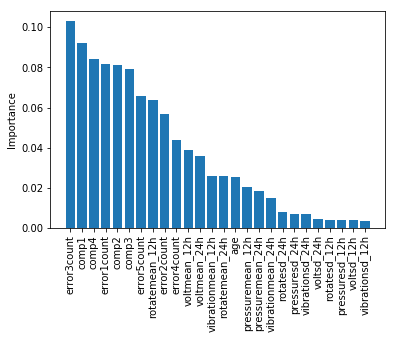

In [544]:
#Below, we plot the feature importances in the trained model
import operator

labels, importances = zip(*sorted(zip(test_x.columns, model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.show()

## Naive Bayes Model

In [545]:
from sklearn.naive_bayes import GaussianNB

In [721]:
%%time
model = GaussianNB()
model.fit(train_x, train_y)

Wall time: 951 ms


In [722]:
gnbtest['predicted_failure'] = model.predict(test_x)

In [724]:
confuse = pd.crosstab(gnbtest['failure'], gnbtest['predicted_failure'])
confuse

predicted_failure,comp1,comp2,comp3,comp4,none
failure,,,,,
comp1,1129,93,100,75,2536
comp2,94,1664,135,87,3256
comp3,21,32,780,9,1035
comp4,31,69,50,863,1354
none,2745,3653,4737,2787,158744


In [549]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.876939
Precision = 0.231597
Recall = 0.351589
F1 = 0.279248


## Gradient Boosting Classifier

In [725]:
from sklearn.ensemble import GradientBoostingClassifier

In [726]:
%%time
model = GradientBoostingClassifier()
model.fit(train_x, train_y)

Wall time: 13min 2s


In [727]:
gbctest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
gbctest['predicted_failure'] = model.predict(test_x)

In [728]:
confuse = pd.crosstab(gbctest['failure'], gbctest['predicted_failure'])
confuse

predicted_failure,comp1,comp2,comp3,comp4,none
failure,,,,,
comp1,1530,52,11,37,2303
comp2,35,2107,19,23,3052
comp3,10,20,737,8,1102
comp4,12,24,6,1038,1287
none,184,175,68,96,172143


In [729]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.954191
Precision = 0.874031
Recall = 0.411371
F1 = 0.559438


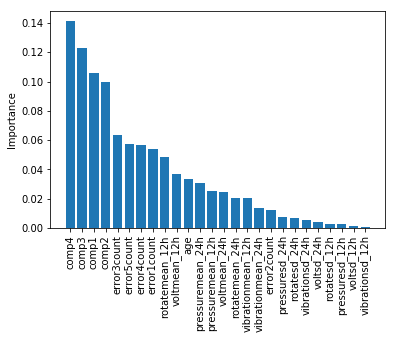

In [730]:
#Below, we plot the feature importances in the trained model

labels, importances = zip(*sorted(zip(test_x.columns, model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.show()

## Neural Network Model

In [41]:
from keras.models import Sequential #neural network for a sequence of layers
from keras.layers import Dense #Standard neural network layer
from keras.layers import Activation #Non-linear functions in the neural network to make it non-linear.
from keras.layers import Dropout

In [47]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
enc = LabelEncoder()
enc.fit(train_y)
train_y = enc.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(train_y)

In [64]:
model = Sequential()
model.add(Dense(26, input_dim=26, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
%%time
model.fit(train_x, train_y, epochs=4)

Epoch 1/4
543281/543281 [==============================] - 18s 33us/step - loss: 1.1367 - acc: 0.9294 9s - loss: 1.1567 - - ETA: 8s - loss: 1. - 
Epoch 2/4
543281/543281 [==============================] - 18s 33us/step - loss: 1.1223 - acc: 0.9303 0s - loss: 1.1221 - acc: 0.9
Epoch 3/4
543281/543281 [==============================] - 18s 33us/step - loss: 1.1224 - acc: 0.9303
Epoch 4/4
543281/543281 [==============================] - 18s 33us/step - loss: 1.1225 - acc: 0.9303 0s - loss: 1.1228 - acc: 0.930
Wall time: 1min 12s


In [67]:
nntest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
pred = model.predict(test_x)
pred = np.argmax(pred, axis=1) 
nntest['predicted_failure'] = enc.inverse_transform(pred)

D:\Workspace\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
confuse = pd.crosstab(nntest['failure'], nntest['predicted_failure'])
confuse

predicted_failure,none
failure,
comp1,3933
comp2,5236
comp3,1877
comp4,2367
none,172666
